In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def next_batch(dataset, N, i):
    left = i*N % len(dataset[0])
    right = (i+1)*N % len(dataset[0])
    
    if left < right :
        return dataset[0][left:right], dataset[1][left:right]
    else:
        return np.vstack((dataset[0][left:],dataset[0][:right])), np.vstack((dataset[1][left:],dataset[1][:right]))

In [3]:
train_data, test_data = tf.keras.datasets.cifar10.load_data()

In [4]:
# parameters
N = 32   # number of images in a minibatch.
D = 32*32*3   # number of features.
K = 10    # number of classes.

In [5]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

In [11]:
# Initialse the infernce variables
inference.initialize(n_iter= 50000, n_print=100, scale={y: float(len(train_data[0])) / N})

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [12]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for i in range(inference.n_iter):
    X_batch, Y_batch = next_batch(train_data, N, i)
    info_dict = inference.update(feed_dict={x: np.reshape(X_batch,(-1, 32*32*3)), y_ph: np.reshape(Y_batch,(-1))})
    inference.print_progress(info_dict)

50000/50000 [100%] ██████████████████████████████ Elapsed: 122s | Loss: 471549216.000


In [15]:
# Load the test images.
X_test = np.reshape(test_data[0],(-1,32*32*3)).astype(np.float32)
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.reshape(test_data[1],(-1))

In [9]:
# Generate samples the posterior and store them.
n_samples = 10
prob_lst = []

for i in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()

    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test, w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    print(i+1, "steps completed.")


1 steps completed.
2 steps completed.
3 steps completed.
4 steps completed.
5 steps completed.
6 steps completed.
7 steps completed.
8 steps completed.
9 steps completed.
10 steps completed.


[6. 9. 8. ... 5. 6. 2.]
[3 8 8 ... 5 1 7]
[6. 9. 9. ... 6. 6. 6.]
[3 8 8 ... 5 1 7]
[5. 8. 8. ... 5. 5. 5.]
[3 8 8 ... 5 1 7]
[8. 8. 8. ... 3. 8. 7.]
[3 8 8 ... 5 1 7]
[3. 9. 0. ... 5. 4. 0.]
[3 8 8 ... 5 1 7]
[8. 8. 0. ... 4. 4. 4.]
[3 8 8 ... 5 1 7]
[5. 9. 8. ... 5. 6. 4.]
[3 8 8 ... 5 1 7]
[3. 9. 7. ... 7. 7. 7.]
[3 8 8 ... 5 1 7]
[5. 9. 5. ... 5. 5. 5.]
[3 8 8 ... 5 1 7]
[8. 9. 8. ... 4. 4. 4.]
[3 8 8 ... 5 1 7]
Expactation of Accuracy:  0.23761001


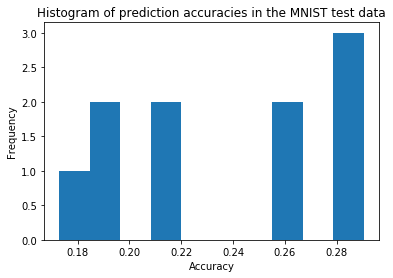

In [16]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    print(y_trn_prd)
    print(Y_test)
    acc = (y_trn_prd == Y_test).mean()
    accy_test.append(acc)

print("Expactation of Accuracy: ", sess.run(tf.reduce_mean(accy_test)))

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [14]:
print(len(Y_test))

10000
